# Generate samples to validate the cosmic ray simulation

In init.sh, change RUN to `run-2024-05-cosmic-setup`

```bash
RUN_NAME=run-2024-05-cosmic-setup
source init.sh


./run_cosmic.sh -n 10000 -r 1 -s Run -d -f -c # Generate 10000 events with run number of 1, run this command interactively without submitting slurm job

# Move the result to a dedicated directory for future use
mkdir -p ${PATH_DATA}/Debug/CosmicGenSetup/
\rm ${PATH_DATA}/Debug/CosmicGenSetup/* -rf
\cp -r cosmic/parma_cpp/GeneOut/run_1 ${PATH_DATA}/Debug/CosmicGenSetup/  
\cp  ${PATH_COSMIC_out}/run_1/*/*/run0.root  ${PATH_DATA}/Debug/CosmicGenSetup/run_1/
\cp  ${PATH_Digi_out}/cosmic_run_1/0/stat0.root  ${PATH_DATA}/Debug/CosmicGenSetup/run_1/

```

In [29]:
run_dir = "/project/rrg-mdiamond/data/MATHUSLA//simulation/run-2024-05-cosmic-setup/Debug/CosmicGenSetup/run_1/"

process_output =  !python3 process_cosmic.py  {run_dir} {run_dir} False
for line in process_output:
    print(line)
    if "Total flux" in line:
        total_flux = float(line.split()[2])
    if "Total events" in line:
        total_events = float(line.split()[2])
        
total_flux,total_events

Cosmic Hit time window [101.58929654974133, 465.2067831617138] 363.6174866119725
Actually, use [0, 600] 600
Total flux 0.047587973 [/cm2/s]
{0: [2112, 0.00534359], 1: [-13, 0.00635307], 2: [13, 0.0074382], 3: [-11, 0.00162953], 4: [22, 0.0237581], 5: [2212, 0.000303893], 6: [11, 0.00276159]}
Processing /project/rrg-mdiamond/data/MATHUSLA/simulation/run-2024-05-cosmic-setup/Debug/CosmicGenSetup/run_1/generation_neutron.out
  events selected: 224/1000
Processing /project/rrg-mdiamond/data/MATHUSLA/simulation/run-2024-05-cosmic-setup/Debug/CosmicGenSetup/run_1/generation_muon.out
  events selected: 267/1000
Processing /project/rrg-mdiamond/data/MATHUSLA/simulation/run-2024-05-cosmic-setup/Debug/CosmicGenSetup/run_1/generation_muonbar.out
  events selected: 313/1000
Processing /project/rrg-mdiamond/data/MATHUSLA/simulation/run-2024-05-cosmic-setup/Debug/CosmicGenSetup/run_1/generation_electronbar.out
  events selected: 68/1000
Processing /project/rrg-mdiamond/data/MATHUSLA/simulation/run-2

(0.047587973, 2000.0)

In [40]:
filename = run_dir + "/run0.root"
tfile = io.open(filename)
Tree  = io.get_tree(tfile)
n_sim_recorded = Tree.GetEntries()
print("Actual simulate output events: ", n_sim_recorded)

Actual simulate output events:  589


In [41]:
# Each simulated events will correspond to a flux of 
flux_real = total_flux / total_events * n_sim_recorded

radius = 35_00 # [cm]
total_area = 3.1415926*radius**2
time_window = 600e-9 #[s]
expected_cosmic_ray_per_event = flux_real*total_area*time_window
print("Each recorded event corresponds to a flux of ",  flux_real, "[/cm2/s]")
print("Average number of cosmic ray per event", expected_cosmic_ray_per_event)

Each recorded event corresponds to a flux of  0.0140146580485 [/cm2/s]
Average number of cosmic ray per event 0.3236083432227306


# Check the PARMA output

In [90]:
label_map={'generation_neutron.out': "n",
            'generation_muon.out': "$\mu^-$",
            'generation_muonbar.out': "$\mu^+$",
            'generation_electronbar.out': "$e^+$",
            'generation_photon.out': "$\gamma$",
            'generation_proton.out': "p",
            'generation_electron.out': "$e^-$"}

Processing /project/rrg-mdiamond/data/MATHUSLA/Debug/CosmicGenSetup/run_1/generation_neutron.out
[  1.036417  35.03856    9.212745  46.88449   66.41905  792.8318
  67.2176   148.0716    24.42079  370.5817  ] 940.6
Processing /project/rrg-mdiamond/data/MATHUSLA/Debug/CosmicGenSetup/run_1/generation_muon.out
[ 3395.897   7568.884   3359.23     792.5273  1987.263  16044.82
  5658.714    766.0641   324.0878 26692.43  ] 105.6583755
Processing /project/rrg-mdiamond/data/MATHUSLA/Debug/CosmicGenSetup/run_1/generation_muonbar.out
[  501.0028   383.399    445.3929 20425.76    8274.032   4121.402
   795.4544   310.9418 15583.13   14664.2   ] 105.6583755
Processing /project/rrg-mdiamond/data/MATHUSLA/Debug/CosmicGenSetup/run_1/generation_electronbar.out
[ 3.975483 32.62326   1.784166 12.93422  34.28691   2.910764  5.60317
 70.46501  15.46447   5.086096] 0.51099895
Processing /project/rrg-mdiamond/data/MATHUSLA/Debug/CosmicGenSetup/run_1/generation_photon.out
[  1.53289   13.09819  133.4404    87.

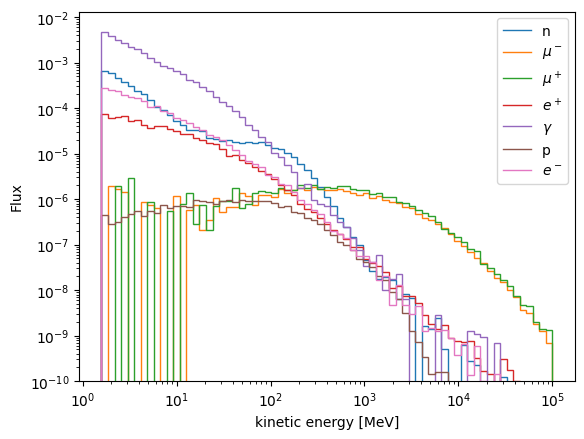

In [92]:
labels=["$\mu^-$", "$\mu^+$","$e^+$","$e^-$"]
for i in range(len(filenames)):
    print("Processing",filenames[i])
    [pid, flux] = file_info[i]
    data = cosmic_data(filenames[i])
    energy = data[:,0]
    mass = particle_mass[abs(pid)]
    print(energy[:10], mass)
    momentum = np.sqrt(energy**2 + 2*energy*mass)    
    bins=np.logspace(0.2, 5, 70)
    n,ibins = np.histogram(energy, bins=bins)
    weight = 1/np.diff(bins) * flux/sum(n)
    stairs(n*weight, ibins, label=label_map[os.path.basename(filenames[i])])
    
#     hist(energy, histtype="step", bins=bins, label=os.path.basename(filenames[i]).split("_")[1].split(".")[0])
xlabel("kinetic energy [MeV]")    
# xlabel("Momentum [MeV/c]")
ylabel("Flux")
xscale("log")
yscale("log")
ylim(1e-10,)
legend()

# Check the simulation input (after some coordinate conversion)

In [42]:
%run process_cosmic.py  {run_dir} {run_dir} False

Cosmic Hit time window [101.58929654974133, 465.2067831617138] 363.6174866119725
Actually, use [0, 600] 600
Total flux 0.047587973 [/cm2/s]
{0: [2112, 0.00534359], 1: [-13, 0.00635307], 2: [13, 0.0074382], 3: [-11, 0.00162953], 4: [22, 0.0237581], 5: [2212, 0.000303893], 6: [11, 0.00276159]}
Processing /project/rrg-mdiamond/data/MATHUSLA/simulation/run-2024-05-cosmic-setup/Debug/CosmicGenSetup/run_1/generation_neutron.out
  events selected: 224/1000
Processing /project/rrg-mdiamond/data/MATHUSLA/simulation/run-2024-05-cosmic-setup/Debug/CosmicGenSetup/run_1/generation_muon.out
  events selected: 267/1000
Processing /project/rrg-mdiamond/data/MATHUSLA/simulation/run-2024-05-cosmic-setup/Debug/CosmicGenSetup/run_1/generation_muonbar.out
  events selected: 313/1000
Processing /project/rrg-mdiamond/data/MATHUSLA/simulation/run-2024-05-cosmic-setup/Debug/CosmicGenSetup/run_1/generation_electronbar.out
  events selected: 68/1000
Processing /project/rrg-mdiamond/data/MATHUSLA/simulation/run-2

In [43]:
for key in data_combined:
    data_combined[key] = np.array(data_combined[key])

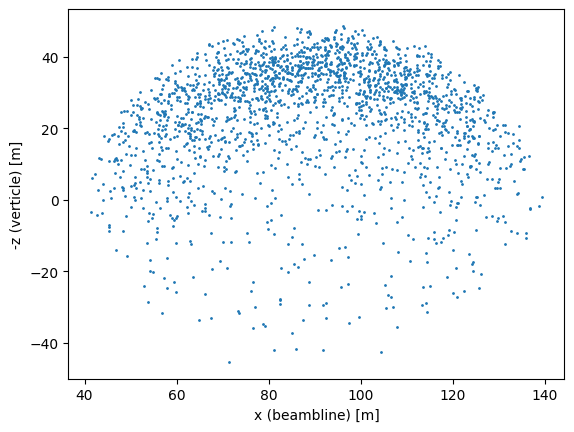

In [54]:
scatter(data_combined["x"]*0.001,-data_combined["z"]*0.001, s=1)
xlabel("x (beambline) [m]")
ylabel("-z (verticle) [m]")
show()

7473 24443


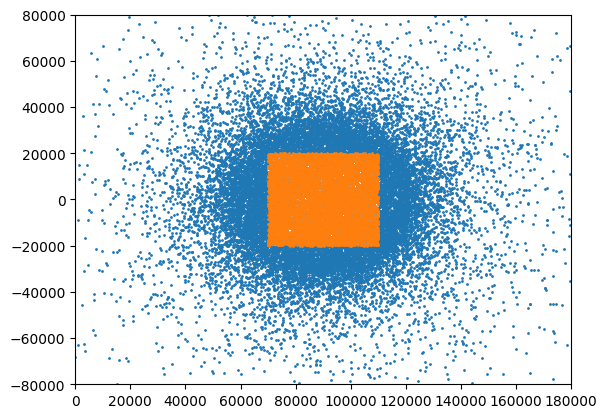

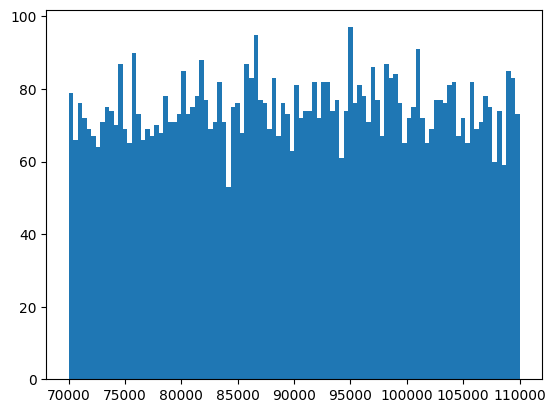

In [70]:
# At a particular Z：
z0=-15000
x_z0 = data_combined["x"] + (z0-data_combined["z"])* data_combined["px"]/data_combined["pz"]
y_z0 = data_combined["y"] + (z0-data_combined["z"])* data_combined["py"]/data_combined["pz"]


mask = (abs(y_z0)<20e3)&(abs(x_z0-90e3)<20e3)
print(sum(mask), len(mask))

scatter(x_z0, y_z0, s=1)
scatter(x_z0[mask], y_z0[mask], s=1)
xlim(0,180000)
ylim(-80e3, 80e3)
show()
hist(x_z0[mask], bins=100);

In [71]:
for key in data_combined:
    data_combined[key] = np.array(data_combined[key])
    
p_h = np.linalg.norm([data_combined["py"],data_combined["px"]], axis=0)
p = np.linalg.norm([data_combined["py"],data_combined["px"],data_combined["pz"]], axis=0)

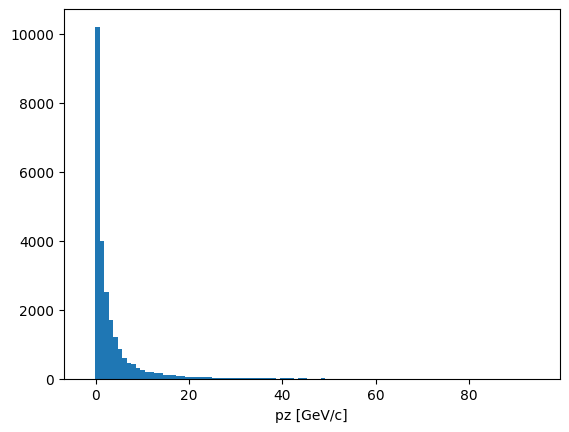

Text(0.5, 0, 'theta')

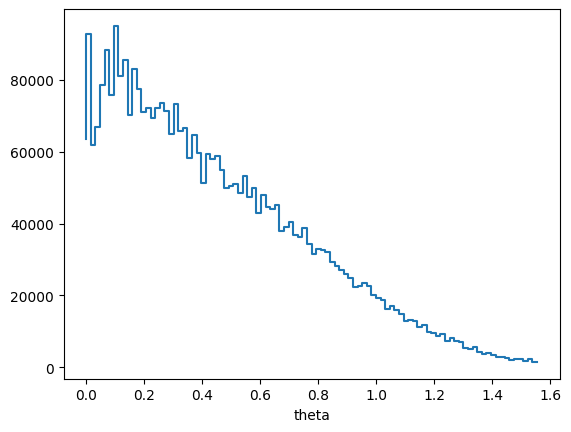

In [72]:
# hist(data_combined["pz"]*0.001, bins=100);
# xlabel("pz [GeV/c]")
# show()


# bins = np.linspace(0,np.pi/2, 100)
# bincenter = 0.5*(bins[:-1] + bins[1:])
# binwidth = np.diff(bins) * np.sin(bincenter)
# n,ibnis=np.histogram(np.arcsin(p_h/p), bins=bins)

# step(ibnis[:-1], n/binwidth)
# xlabel("theta")

# Check the simulation output

In [48]:
import tracker.io_user.io_MuSim as io
import sys, importlib
ana_helper_path = "/project/def-mdiamond/tomren/jupyter/Mu-helper/muhelper/"
sys.path.append(ana_helper_path)

from pylab import *

# modules in this directory
import visualization, util, event, cutflow, detector
importlib.reload(event)
importlib.reload(visualization)
importlib.reload(util)
importlib.reload(detector)
import visualization as vis
import helper_pytracker as hpt


In [49]:
# filename = "/project/rrg-mdiamond/data/MATHUSLA/Debug/CosmicGenSetup/run_1//run0.root"
filename = run_dir+"/run0.root"

tfile = io.open(filename)
Tree  = io.get_tree(tfile)
print(Tree.GetEntries())

589


In [1]:
# import ROOT
# filename="/project/rrg-mdiamond/data/MATHUSLA/share/stat1.root"

# tfile = ROOT.TFile.Open(filename)
# tree_name = tfile.GetListOfKeys()[0].GetName()
# Tree = tfile.Get(tree_name)

# branches = [Tree.GetListOfBranches()[i].GetName() for i in range(len(Tree.GetListOfBranches()))]
# entries = Tree.GetEntries()

# print("Branches", branches)
# print("Entries", entries)

# Tree.GetEntry(1)
# Tree.Digi_track_id

Welcome to JupyROOT 6.28/10


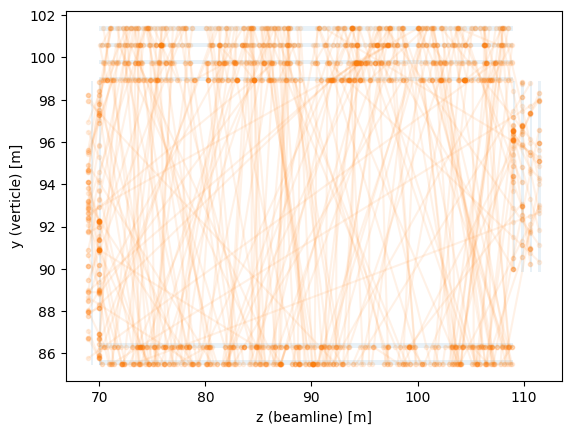

In [55]:
# filename = f"/project/rrg-mdiamond/tomren/mudata/tests/new_geometry//20240318/152454/run0.root"
# filename = f"{filenames[0]}/run0.root"
# tfile = root.TFile.Open(filename)

# tree_name = ["integral_tree","box_run"][1]
# tree_name = tfile.GetListOfKeys()[0].GetName()

ev = event.Event(filename, 0, tree_name="box_run")
for i in range(500):
    ev.EventNumber=i

    tracks=ev.get_truthtrack()
    if len(tracks)>0:
        for track in tracks:
            # track=util.coord_cms2det(track)
            plt.plot(track[2]*0.01,track[1]*0.01,marker=".",color="C1",alpha=0.1)    
        
    plt.xlabel('z (beamline) [m]')
    plt.ylabel('y (verticle) [m]')
    
hpt.visualization.drawdet(0, unit="m")